In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=3
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
# needs treshold  3 QuatreCamins, 2 SantBoi 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  3516.6577380952117
Friday area:  3082.0952380952285
Weekend area:  523.6141262509632
Weekday maximum:  144.64285714285714
Friday maximum:  140.71428571428572
Weekend maximum:  26.775981524249424


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

#parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if bolTrainagain:
    errors_wd = np.ones(np.shape(training_weekdays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*wd_length)

    optimal_params_weekdaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_weekdays_norm,training_weekdays_isfull,errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
else:
    #load data
    with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [5]:
var_weekdaytn_time = np.mean(errors_wd)
#var_weekdaytn = optimal_params_weekdaytn.fun/np.size(training_weekdays_norm)
stdv_weekdaytn=math.sqrt(var_weekdaytn_time)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.05425



In [6]:
optimal_params_weekdaytn

 final_simplex: (array([[0.31383963, 0.03621748, 0.80902433, ..., 0.7261689 , 0.73093133,
        0.71026415],
       [0.31383962, 0.03621743, 0.80902429, ..., 0.72616862, 0.73093135,
        0.71026431],
       [0.31383961, 0.03621745, 0.80902433, ..., 0.72616875, 0.73093115,
        0.7102641 ],
       ...,
       [0.31383963, 0.03621744, 0.80902434, ..., 0.72616874, 0.73093142,
        0.71026423],
       [0.31383962, 0.03621747, 0.80902436, ..., 0.72616904, 0.73093146,
        0.71026411],
       [0.31383964, 0.03621744, 0.80902432, ..., 0.72616875, 0.73093142,
        0.71026431]]), array([3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
   

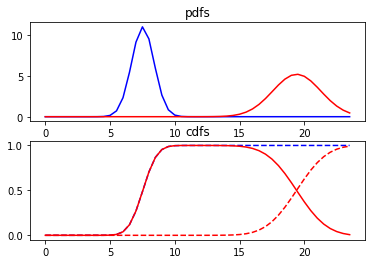

In [7]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [8]:
optimal_params_weekdayth=np.mean(optimal_params_weekdaytn.x[4:])

In [9]:
optimal_params_weekdayth

0.795802575658487

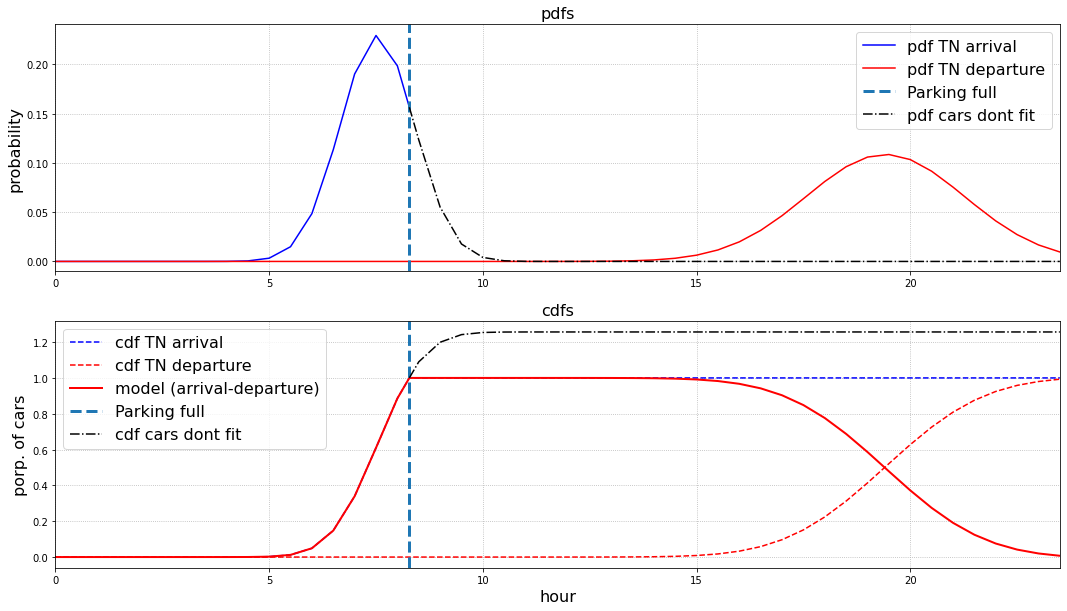

In [10]:
fid=plot_model_tn_thDisc(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],
              optimal_params_weekdaytn.x[3],optimal_params_weekdayth)
fid.savefig('Model_'+current_parking+'.pdf',bbox_inches='tight');

In [11]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.31383963, 0.03621748, 0.80902433, 0.0772256 , 0.76561431,
       0.62051281, 0.85422873, 0.86941477, 0.82320583, 0.87775692,
       0.92357488, 0.87157498, 0.8335844 , 0.83529347, 0.8482066 ,
       0.82297959, 0.83987068, 0.84802219, 0.80918356, 0.80282006,
       0.80040425, 0.79872722, 0.81020112, 0.80603411, 0.73694148,
       0.73420851, 0.7261689 , 0.72622504, 0.73035329, 0.7261689 ,
       0.73093133, 0.71026415])

In [12]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
prototype_math_arr_weekday=cdf1_wd
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
prototype_math_dep_weekday=cdf2_wd
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd#/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


In [13]:
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])

ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdayth)
t_parking_full=np.interp(optimal_params_weekdayth,cdf1_wd,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)

tn1_wd_unmodifed=tn1_wd
tn1_wd=np.insert(tn1_wd,ix_parking_full,np.interp(t_parking_full,time2,tn1_wd))
tn1_wd_excees=tn1_wd.copy()
tn1_wd[ix_parking_full+1:] =0
tn1_wd_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_wd), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_wd), dtype=bool)
masktn1_excees[:ix_parking_full] =False

#tn1_wd[cdf1_wd>optimal_params_weekdayth] =0
#tn1_wd_excees[cdf1_wd<optimal_params_weekdayth] =0
cdf1_wd[cdf1_wd>optimal_params_weekdayth] = optimal_params_weekdayth
cdf1_wd_plot=np.insert(cdf1_wd,ix_parking_full,optimal_params_weekdayth)

cdf1_wd = cdf1_wd/optimal_params_weekdayth
cdf1_wd_plot = cdf1_wd_plot/optimal_params_weekdayth

cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
cdf2_wd_plot=np.insert(cdf2_wd,ix_parking_full,np.interp(t_parking_full,time2,cdf2_wd))
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
resta_wd_plot = np.array(cdf1_wd_plot) - np.array(cdf2_wd_plot)
prototype_math_weekday = resta_wd#/sum(resta_wd)
prototype_math_weekday_plot = resta_wd_plot#/sum(resta_wd)
#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2_th[masktn1], tn1_wd[masktn1]/sum(tn1_wd_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_wd_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_wd_plot, label="Cummulative probability departure")

#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_wd_excees[masktn1_excees]/sum(tn1_wd_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

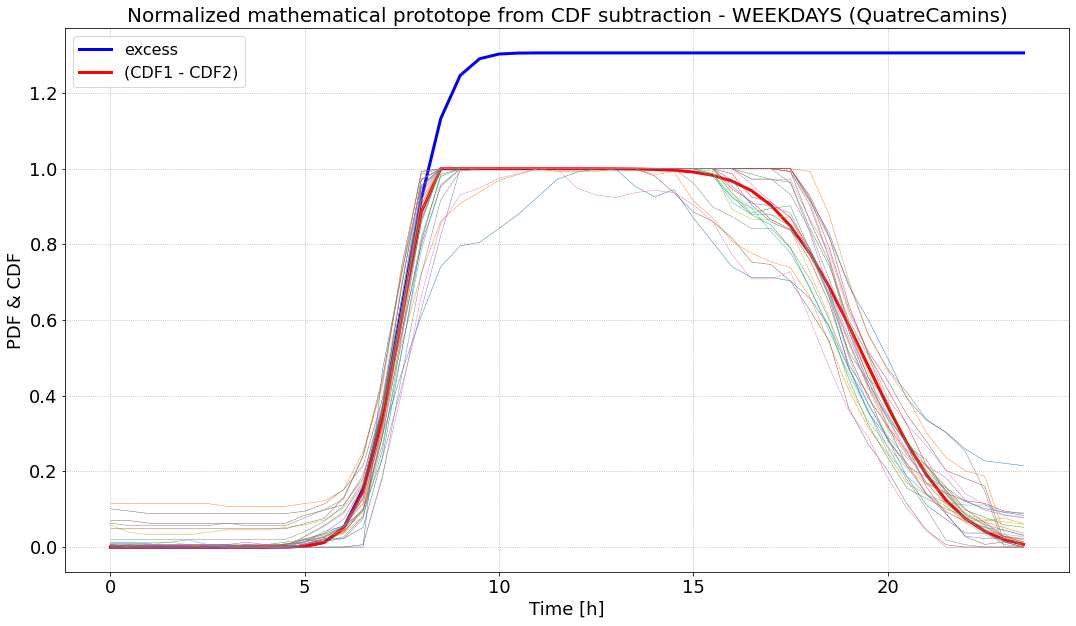

In [14]:
fig = plt.figure(figsize=(18,10))
plt.title("Normalized mathematical prototope from CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time2, prototype_math_arr_weekday/optimal_params_weekdaytn.x[4], linewidth=3, color='blue', label="excess")
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    plt.plot(time, training_weekdays_norm[i], linewidth=0.45)

plt.legend(fontsize=16, loc="upper left");

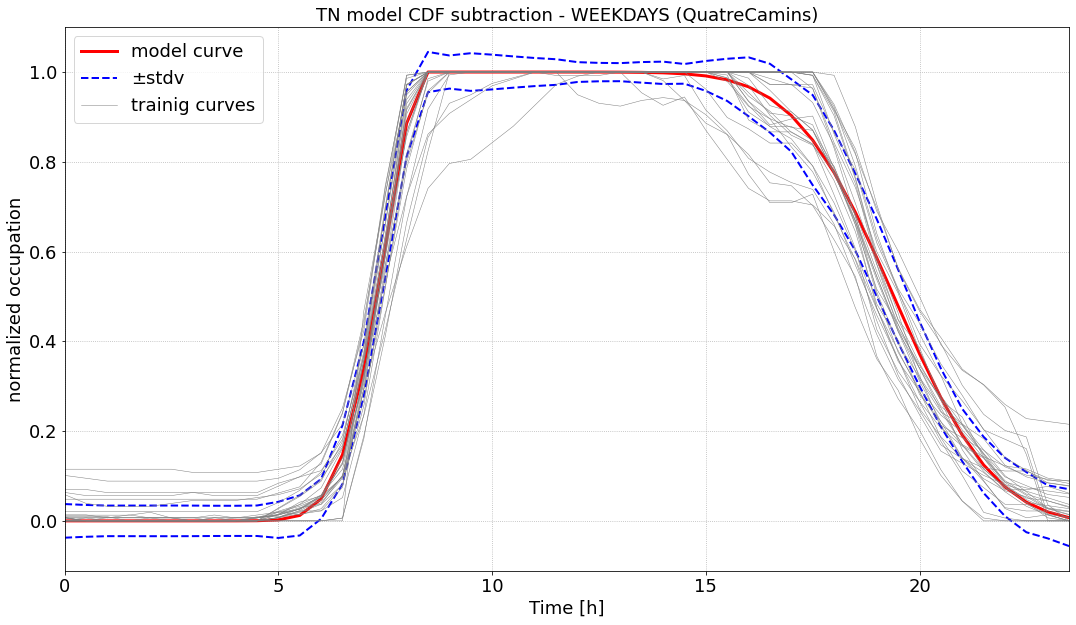

In [15]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

In [16]:
bol_plot_individual_fits = False
if bol_plot_individual_fits: 
    tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
    tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    for ii in range(0,len(training_weekdays_norm)):
        idx_th=ii+4

        cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])


        dayisFull=training_weekdays_isfull[ii]
        if dayisFull:
            print(optimal_params_weekdaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] =0
            cdf1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] = optimal_params_weekdaytn.x[idx_th]
            cdf1_wd = cdf1_wd/optimal_params_weekdaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
        prototype_math_weekday = resta_wd#/sum(resta_wd)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - weekdayS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_weekdays_norm)):
        plt.plot(time, training_weekdays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### FRIDAYS

In [17]:
if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*f_length)
    optimal_params_fridaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_fridays_norm,training_fridays_isfull,errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})



In [18]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
#print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.05573



In [19]:
optimal_params_fridaytn

 final_simplex: (array([[0.32164844, 0.03851972, 0.77068313, 0.11790025, 0.68350776,
        0.82301888, 0.87377744, 0.68089001, 0.68089114, 0.68089001,
        0.69284511],
       [0.32164843, 0.03851971, 0.7706832 , 0.11790018, 0.68350732,
        0.82301856, 0.8737774 , 0.68089046, 0.68089159, 0.68089046,
        0.69284568],
       [0.32164842, 0.03851971, 0.77068317, 0.11790015, 0.68350747,
        0.82301872, 0.87377736, 0.6808905 , 0.68089163, 0.6808905 ,
        0.69284576],
       [0.32164844, 0.0385197 , 0.7706833 , 0.11790022, 0.68350703,
        0.82301821, 0.87377726, 0.68089068, 0.68089181, 0.68089068,
        0.69284601],
       [0.32164845, 0.03851972, 0.77068321, 0.1179001 , 0.68350696,
        0.82301841, 0.87377732, 0.68089087, 0.680892  , 0.68089087,
        0.69284595],
       [0.32164845, 0.03851971, 0.77068322, 0.11790025, 0.68350715,
        0.82301827, 0.87377769, 0.68089014, 0.68089127, 0.68089014,
        0.69284534],
       [0.3216484 , 0.03851971, 0.7706831

In [20]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [21]:
optimal_params_fridaytn.x[4:]

array([0.68350776, 0.82301888, 0.87377744, 0.68089001, 0.68089114,
       0.68089001, 0.69284511])

In [22]:
optimal_params_fridayth=np.mean(optimal_params_fridaytn.x[4:])

In [23]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta#/sum(resta)
#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

In [24]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
prototype_math_arr_friday=cdf1_fri.copy()

ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridayth)
t_parking_full=np.interp(optimal_params_fridayth,cdf1_fri,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)


tn1_fri_unmodifed=tn1_fri
tn1_fri=np.insert(tn1_fri,ix_parking_full,np.interp(t_parking_full,time2,tn1_fri))
tn1_fri_excees=tn1_fri.copy()
tn1_fri[ix_parking_full+1:] =0
tn1_fri_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_fri), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_fri), dtype=bool)
masktn1_excees[:ix_parking_full] =False

cdf1_fri[cdf1_fri>optimal_params_fridayth] = optimal_params_fridayth
cdf1_fri_plot=np.insert(cdf1_fri,ix_parking_full,optimal_params_fridayth)

cdf1_fri = cdf1_fri/optimal_params_fridayth
cdf1_fri_plot = cdf1_fri_plot/optimal_params_fridayth

cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])
cdf2_fri_plot=np.insert(cdf2_fri,ix_parking_full,np.interp(t_parking_full,time2,cdf2_fri))
prototype_math_dep_friday=cdf2_fri
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
resta_fri_plot = np.array(cdf1_fri_plot) - np.array(cdf2_fri_plot)
prototype_math_friday = resta_fri#/sum(resta_wd)
prototype_math_friday_plot = resta_fri_plot

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)

#plt.plot(time2_th[masktn1], tn1_fri[masktn1]/sum(tn1_fri_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_fri_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_fri_plot, label="Cummulative probability departure")
#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_fri_excees[masktn1_excees]/sum(tn1_fri_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

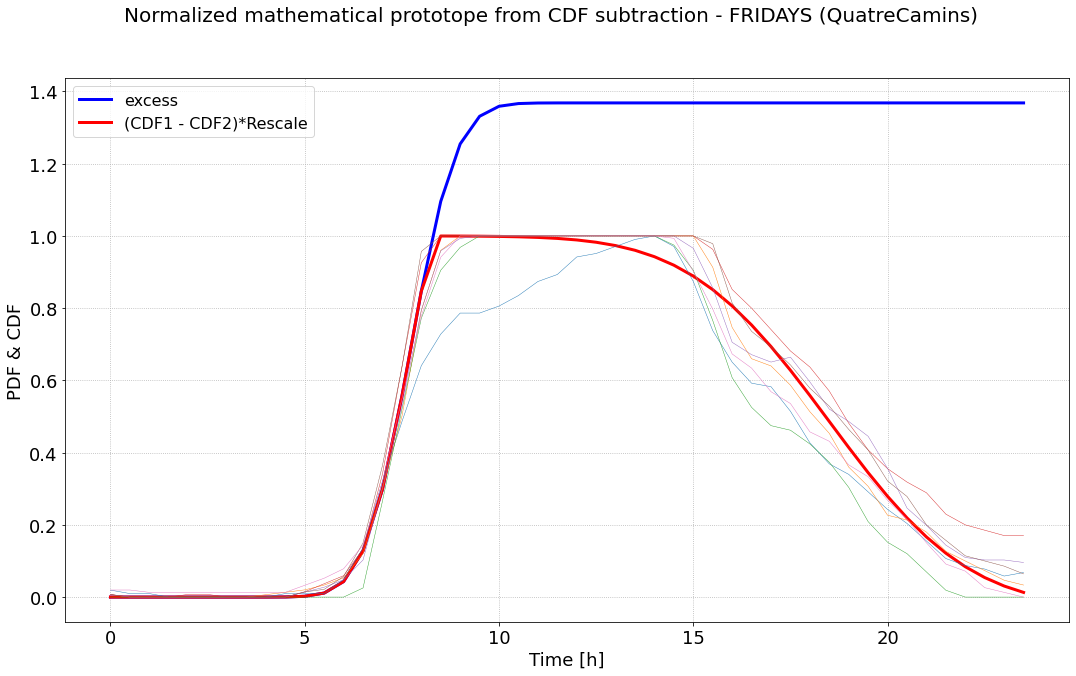

In [25]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time, prototype_math_arr_friday/optimal_params_fridayth, linewidth=3, color='blue', label="excess")
plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_fridays_norm)):
    plt.plot(time, training_fridays_norm[i], linewidth=0.45)
plt.legend(fontsize=16);

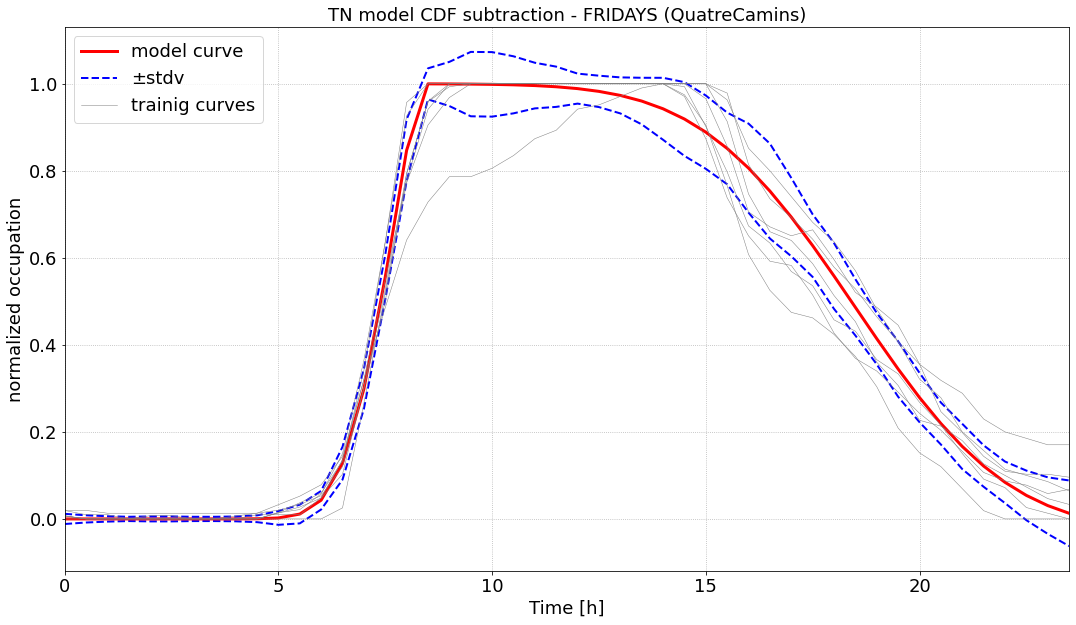

In [26]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

In [27]:
bol_plot_individual_fits = False
if bol_plot_individual_fits:
    tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
    tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    for ii in range(0,len(training_fridays_norm)):
        idx_th=ii+4

        cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])


        dayisFull=training_fridays_isfull[ii]
        if dayisFull:
            print(optimal_params_fridaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] =0
            cdf1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] = optimal_params_fridaytn.x[idx_th]
            cdf1_fri = cdf1_fri/optimal_params_fridaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
        prototype_math_friday = resta_fri#/sum(resta_fri)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_fridays_norm)):
        plt.plot(time, training_fridays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### WEEKENDS

In [28]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))  
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors),
                                    method='SLSQP',
                                    bounds=((0, None), (0, None),(0, None),(0, None)),
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


In [29]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFitTH.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [30]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 1.00000



In [31]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([4.23756984e-01, 1.20748554e-01, 6.40233090e+04, 1.10398231e+02])

In [32]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we#/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

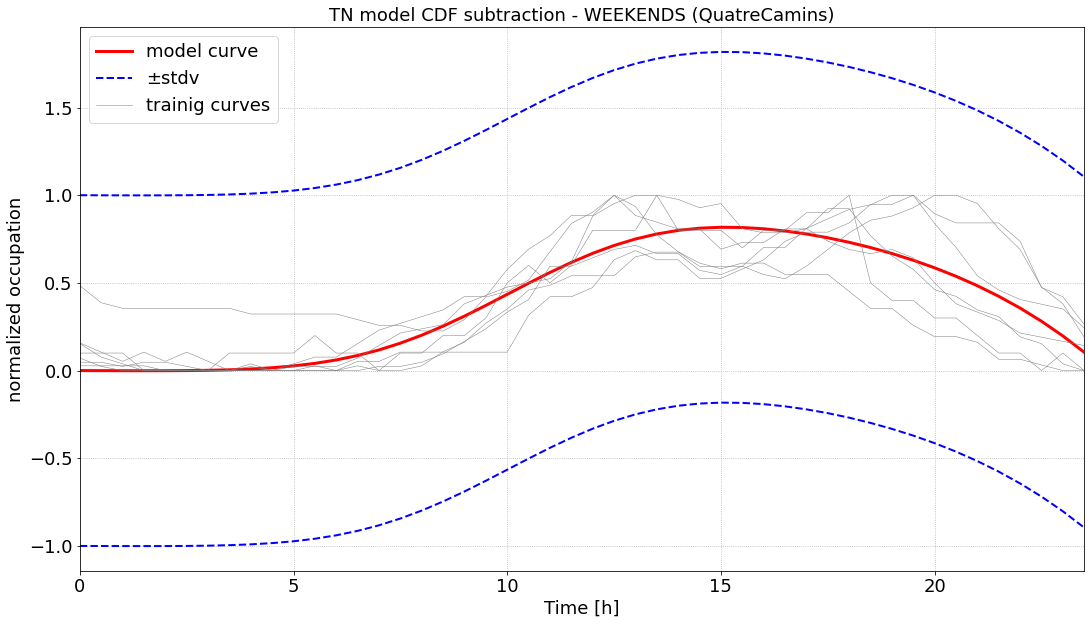

In [33]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [34]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS QuatreCamins -----------
Mean Arrival Time   = 07:31h
stdv Arrival        =  0:52h
Mean Departure Time = 19:24h
stdv Departure      =  1:51h
Parking full        = 08:30h
--------- FRIDAYS QuatreCamins -----------
Mean Arrival Time   = 07:43h
stdv Arrival        =  0:55h
Mean Departure Time = 18:29h
stdv Departure      =  2:49h
Parking full        = 08:30h
--------- WEEKENDS QuatreCamins -----------
Mean Arrival Time   = 10:10h
stdv Arrival        =  2:53h
Mean Departure Time = 1536559:24h
stdv Departure      = 2649:33h


In [35]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

tn_arr_weekday_n = prototype_math_arr_weekday
tn_dep_weekday_n = prototype_math_dep_weekday
tn_arr_friday_n = prototype_math_arr_friday
tn_dep_friday_n = prototype_math_dep_friday

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [36]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_max + weekday_offset
tn_arr_weekday = tn_arr_weekday_n*weekday_max + weekday_offset

tn_weekday_nooff = tn_weekday_n*weekday_max 
tn_arr_weekday_nooff = tn_arr_weekday_n*weekday_max 
tn_dep_weekday = tn_dep_weekday_n*weekday_max #+ weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_max + friday_offset
tn_arr_friday = tn_arr_friday_n*friday_max + friday_offset

tn_friday_nooff = tn_friday_n*friday_max
tn_arr_friday_nooff = tn_arr_friday_n*friday_max
tn_dep_friday = tn_dep_friday_n*friday_max #+ friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_max + weekend_offset 

tn1_weekend_nooff = tn1_weekend_n*weekend_max 

In [37]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

______ MEAN ± STDV________
5.066463312660243  ±  1.6219919324945788
4.660707946301489  ±  1.6280337209118214
5.3365452962205735  ±  3.5707895547758906
8.060159975741533  ±  4.720550647370504
14.964702013202748  ±  15.86636937021259
9.149935492971593  ±  1.4372362869198276
9.604299746142273  ±  5.016976304475314


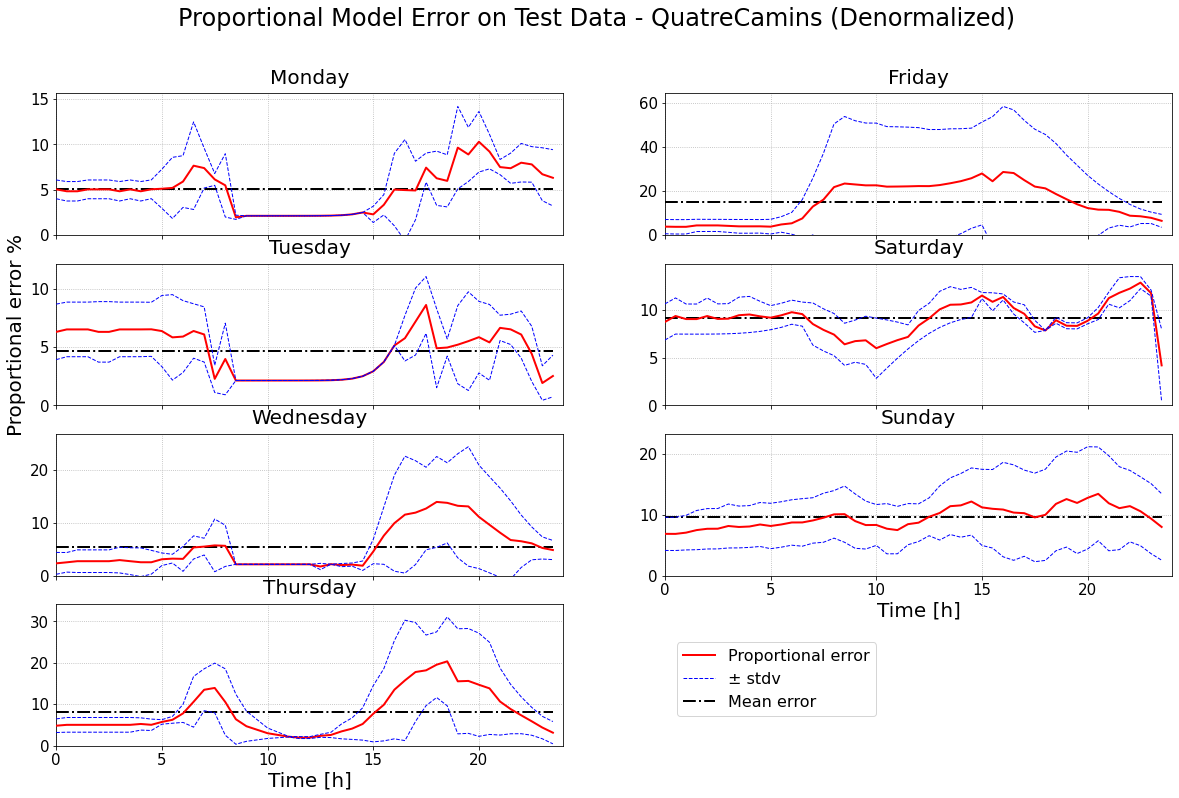

In [38]:


[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv(testing_tuesdays, tn_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv(testing_wednesdays, tn_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv(testing_thursdays, tn_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv(testing_fridays, tn_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv(testing_sundays, tn1_weekend, max_value)



    
fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday', 'Monday',False,False,False,False)

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'th.pdf',bbox_inches='tight');
#ax[1,1].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))


In [39]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [40]:
f = open('data/'+current_parking+'_testErrorTH.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [41]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

In [42]:
def plot_prototype():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
        tn_arr_scaling = get_scaling_factor(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)

        scaled_tn_proto = tn_proto * tn_scaling
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling

        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-weekday_offset)
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = hist_weekday_proto.values * stat_scaling
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

In [43]:
def plot_prototype_fit():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
        tn_arr_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)

        scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
    
        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

#### MONDAY

In [44]:
statistic_proto = hist_weekday_proto
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 20
day = 'Monday'

2020-02-24
Real Monday scaled prtotype error:  2.3 %
Real Monday scaled prtotype STDV:  1.2167152948884925
Real Monday scaled TN error:  2.52 %
Real Monday scaled TN STDV:  2.088620878866165
_____________________________________________________________
2020-03-02
Real Monday scaled prtotype error:  4.52 %
Real Monday scaled prtotype STDV:  1.2128136946131691
Real Monday scaled TN error:  6.22 %
Real Monday scaled TN STDV:  1.2886249380386074
_____________________________________________________________
2020-03-09
Real Monday scaled prtotype error:  3.64 %
Real Monday scaled prtotype STDV:  1.0953310968587227
Real Monday scaled TN error:  2.56 %
Real Monday scaled TN STDV:  0.6412255660367947
_____________________________________________________________


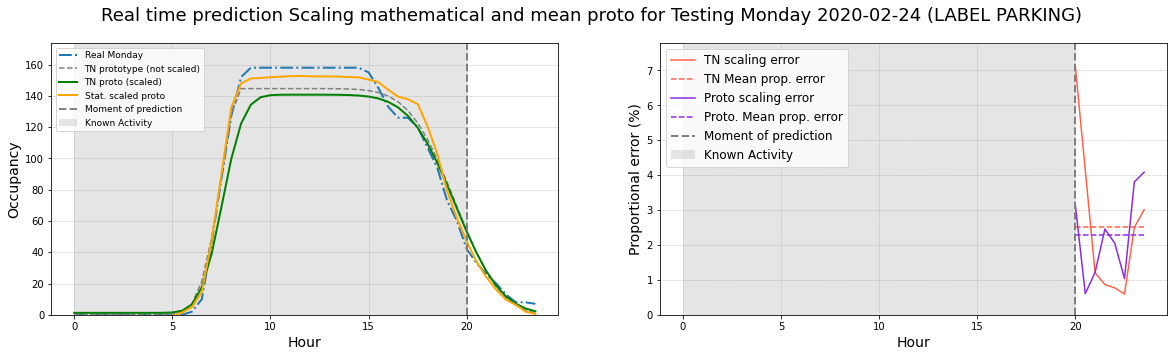

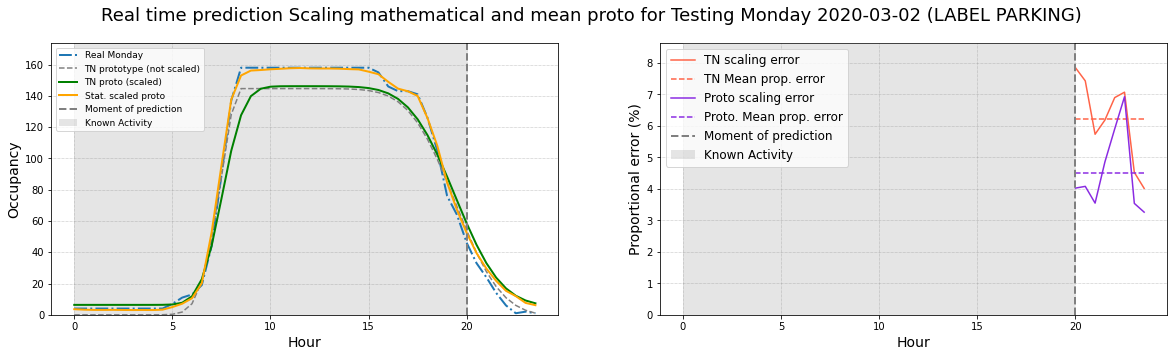

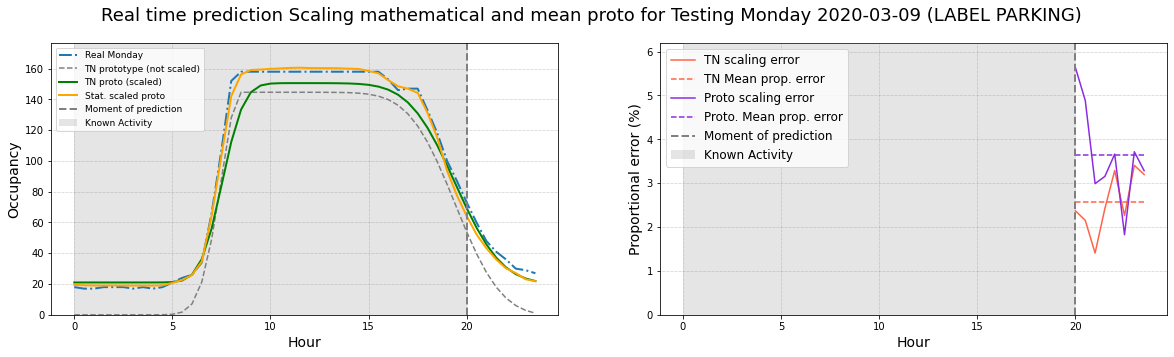

In [45]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fit()

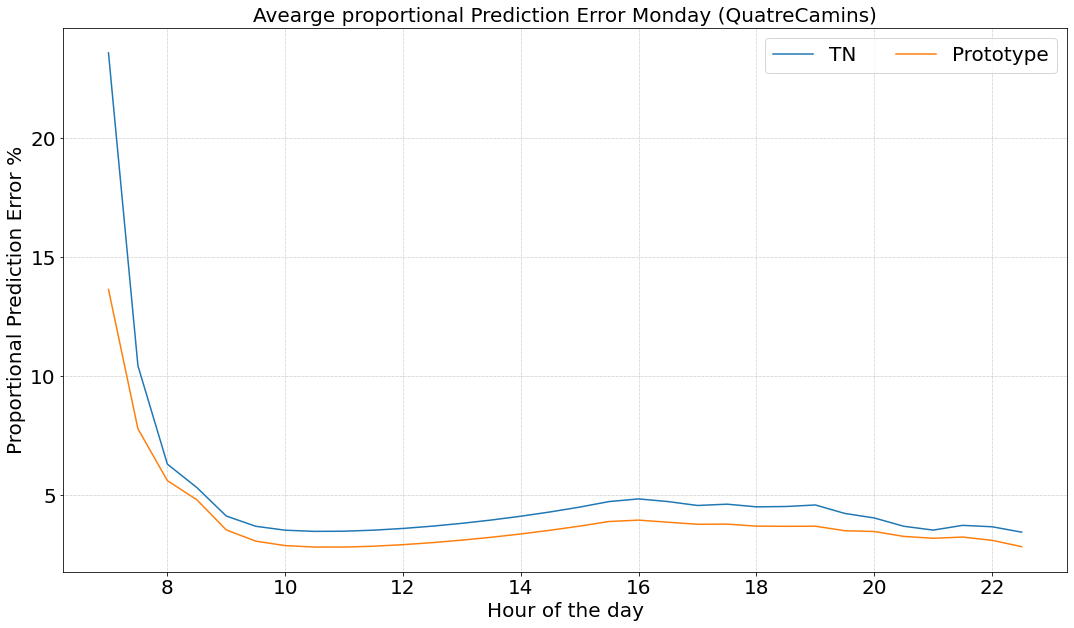

In [46]:
starting_hour=7
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [47]:
def calcRunningPredcitionErrorTH(t_days,hist_weekday_proto,tn_proto,tn_arr_proto,tn_dep_proto,
                                 max_value,starting_hour=7):
    limit_hour_vec = np.arange (starting_hour, 23, 0.5)
    tn_running_error_vec=np.zeros((len(limit_hour_vec),len(t_days)))
    proto_running_error_vec=np.zeros((len(limit_hour_vec),len(t_days)))

    for i in range(0,len(t_days)):
        cont=0
        for limit_hour in limit_hour_vec:
            tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
            tn_arr_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_arr_proto)
            stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
            
            scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
            scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
            scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
            if max(scaled_tn_arr_proto)>max_value:
                #cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
                #print(round(cars_could_not_park), "cars could not park")
                scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
                scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
            scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto
            scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
            [tn_running_error_vec[cont,i],proto_running_error_vec[cont,i]]= \
                errors_calc(scaled_tn_proto2, scaled_stat_proto, t_days[i], limit_hour, max_value)
            cont=cont+1
    return [tn_running_error_vec,proto_running_error_vec]

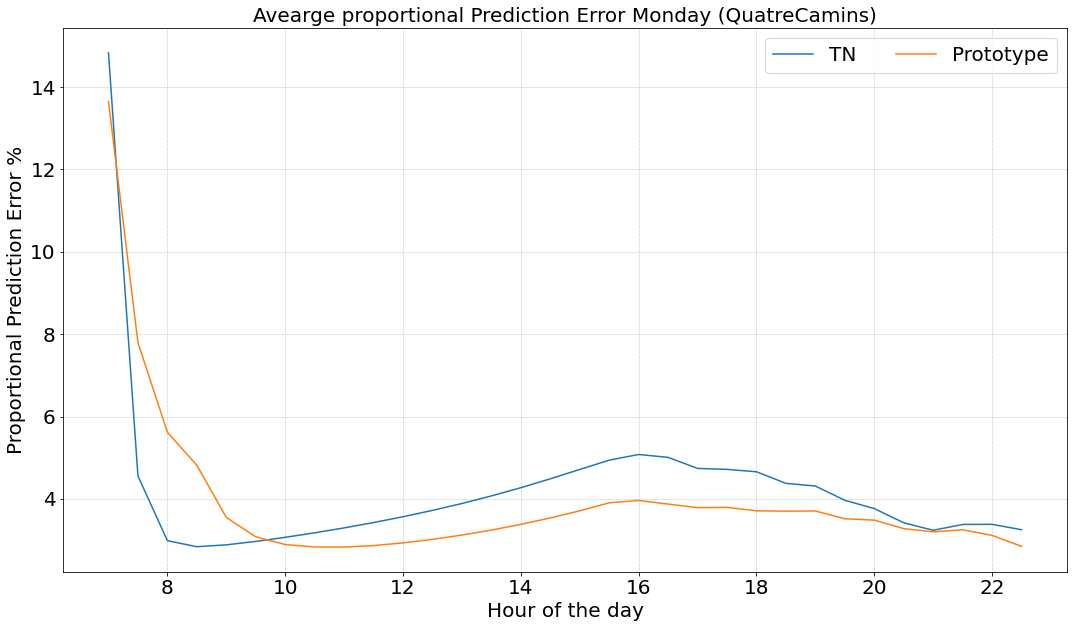

In [48]:
starting_hour=7
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTH(t_days,hist_weekday_proto,
                                                                            tn_proto,tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

2020-02-24
Real Monday scaled prtotype error:  2.18 %
Real Monday scaled prtotype STDV:  1.6504416045366732
Real Monday scaled TN error:  7.27 %
Real Monday scaled TN STDV:  4.6966307123059385
_____________________________________________________________
2020-03-02
Real Monday scaled prtotype error:  5.94 %
Real Monday scaled prtotype STDV:  3.30958263089452
Real Monday scaled TN error:  5.68 %
Real Monday scaled TN STDV:  5.645053447648726
_____________________________________________________________
2020-03-09
Real Monday scaled prtotype error:  1.84 %
Real Monday scaled prtotype STDV:  1.3908316202442605
Real Monday scaled TN error:  18.26 %
Real Monday scaled TN STDV:  4.429890981360034
_____________________________________________________________


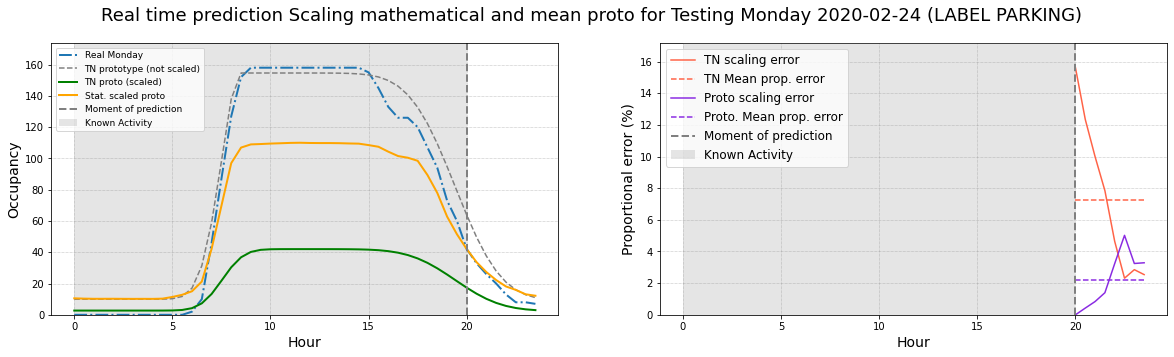

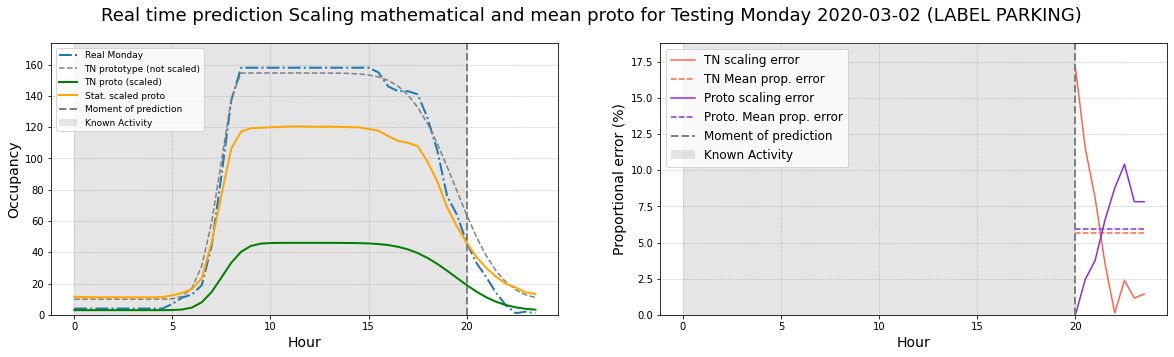

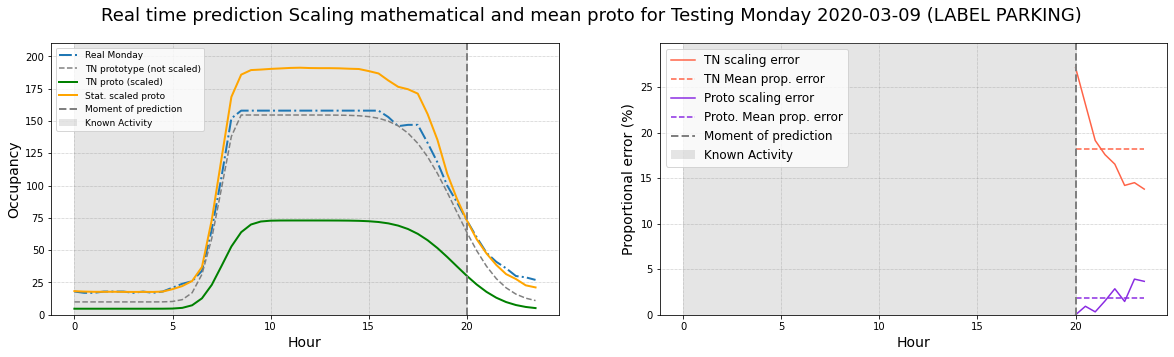

In [49]:
tn_proto = tn_weekday


tn_arr_proto = tn_arr_weekday
tn_dep_proto = tn_dep_weekday
plot_prototype()

#### TUESDAY

2020-02-25
42 cars could not park
Real Tuesday scaled prtotype error:  3.74 %
Real Tuesday scaled prtotype STDV:  2.180650962057507
Real Tuesday scaled TN error:  2.48 %
Real Tuesday scaled TN STDV:  2.929775834848242
_____________________________________________________________
2020-03-03
33 cars could not park
Real Tuesday scaled prtotype error:  3.9 %
Real Tuesday scaled prtotype STDV:  3.0086331457784254
Real Tuesday scaled TN error:  2.84 %
Real Tuesday scaled TN STDV:  3.652448434901149
_____________________________________________________________
2020-03-10
49 cars could not park
Real Tuesday scaled prtotype error:  4.52 %
Real Tuesday scaled prtotype STDV:  2.5740345299742518
Real Tuesday scaled TN error:  2.32 %
Real Tuesday scaled TN STDV:  2.8616809236705327
_____________________________________________________________


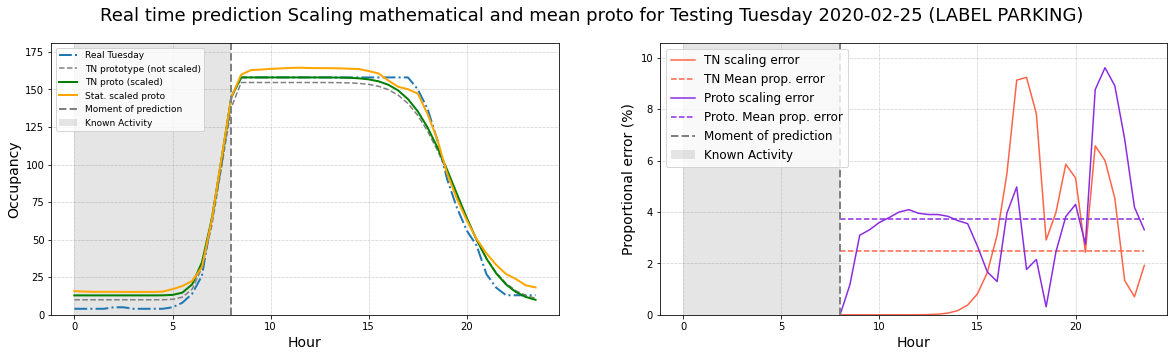

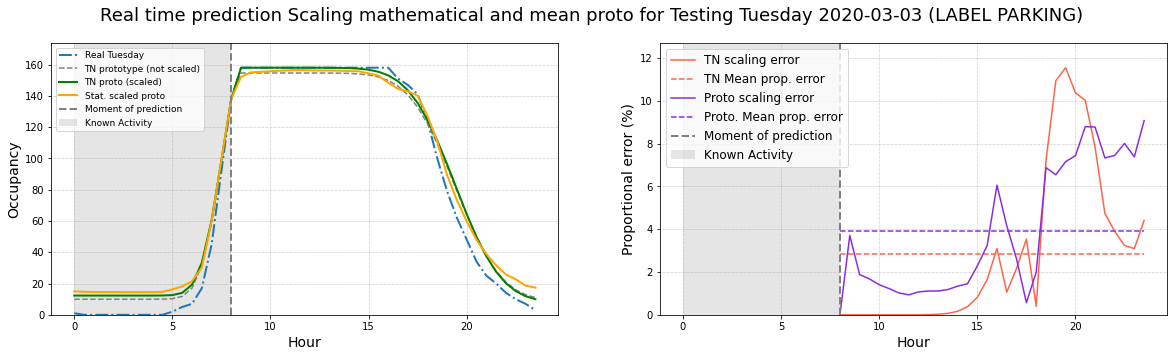

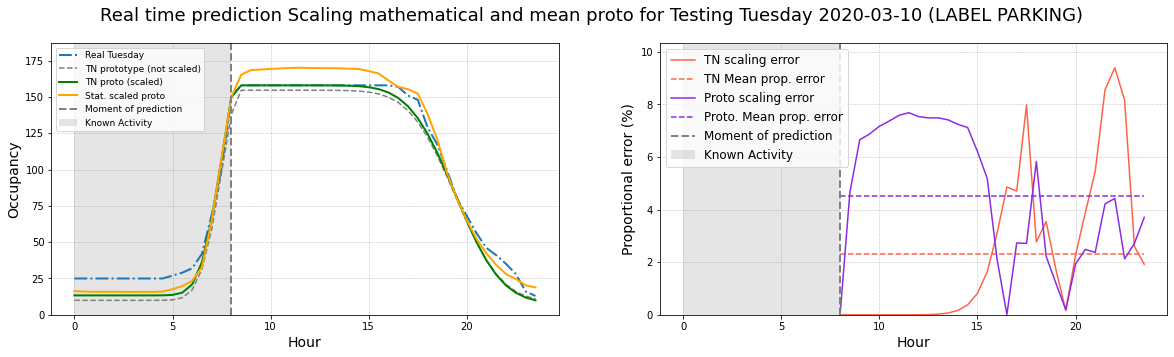

In [50]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 8
day = 'Tuesday'

tn_arr_proto = tn_arr_weekday
tn_dep_proto = tn_dep_weekday
plot_prototype()

### WEDNESDAY

2020-02-26
56 cars could not park
Real Wednesday scaled prtotype error:  6.12 %
Real Wednesday scaled prtotype STDV:  4.279196460207794
Real Wednesday scaled TN error:  2.32 %
Real Wednesday scaled TN STDV:  3.8346978955622038
_____________________________________________________________
2020-03-04
35 cars could not park
Real Wednesday scaled prtotype error:  3.32 %
Real Wednesday scaled prtotype STDV:  3.4345168150361625
Real Wednesday scaled TN error:  2.54 %
Real Wednesday scaled TN STDV:  3.355426320476814
_____________________________________________________________
2020-03-11
44 cars could not park
Real Wednesday scaled prtotype error:  14.84 %
Real Wednesday scaled prtotype STDV:  10.579565826085027
Real Wednesday scaled TN error:  11.24 %
Real Wednesday scaled TN STDV:  11.149810844240731
_____________________________________________________________


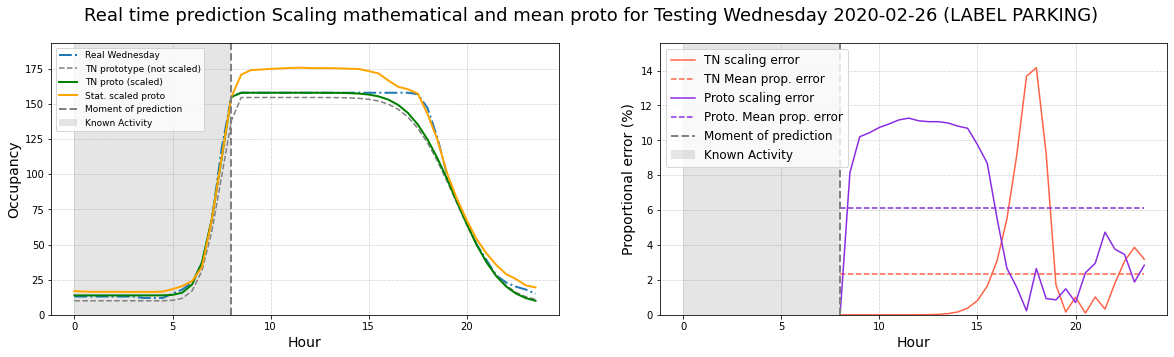

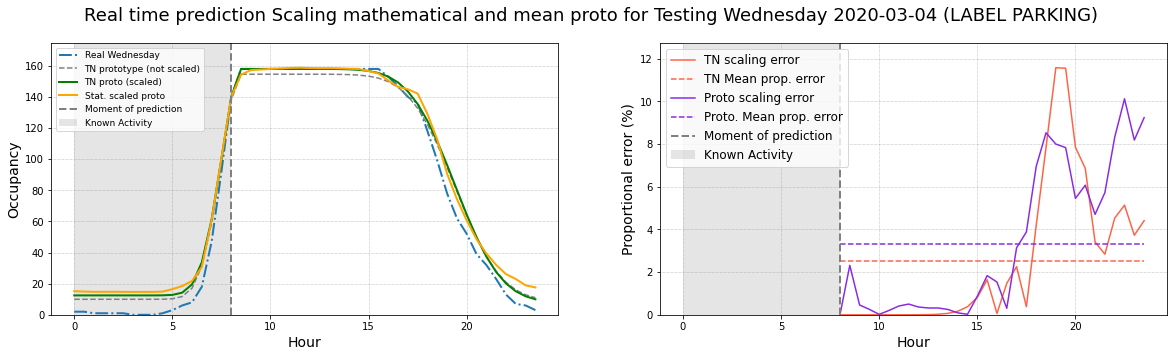

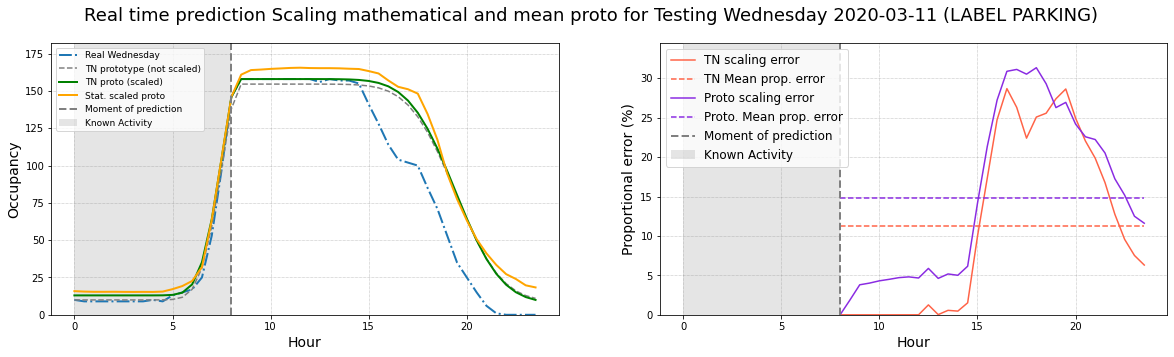

In [51]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 8
day = 'Wednesday'

tn_arr_proto = tn_arr_weekday
tn_dep_proto = tn_dep_weekday
plot_prototype()

### THURSDAY

2020-02-27
56 cars could not park
Real Thursday scaled prtotype error:  7.64 %
Real Thursday scaled prtotype STDV:  4.167969818721817
Real Thursday scaled TN error:  5.02 %
Real Thursday scaled TN STDV:  6.2840521702364605
_____________________________________________________________
2020-03-05
31 cars could not park
Real Thursday scaled prtotype error:  3.35 %
Real Thursday scaled prtotype STDV:  1.9616951841290655
Real Thursday scaled TN error:  1.59 %
Real Thursday scaled TN STDV:  2.0948875894460746
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  13.73 %
Real Thursday scaled prtotype STDV:  5.322172687926732
Real Thursday scaled TN error:  12.75 %
Real Thursday scaled TN STDV:  11.30570061395234
_____________________________________________________________


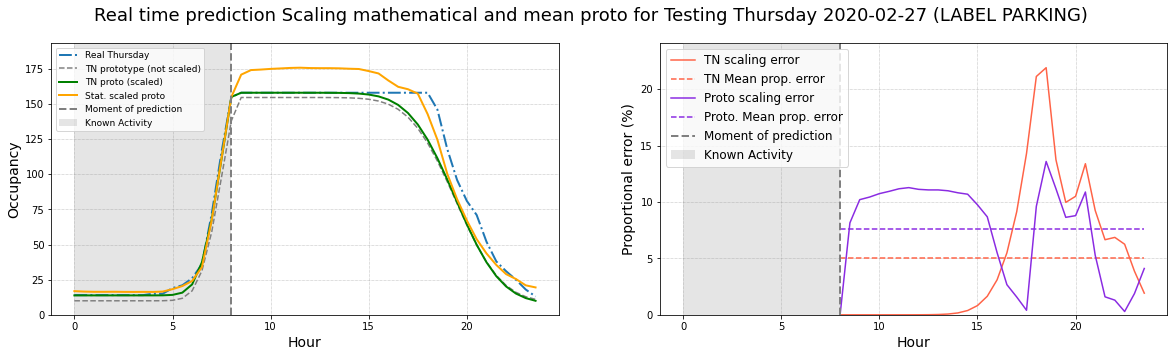

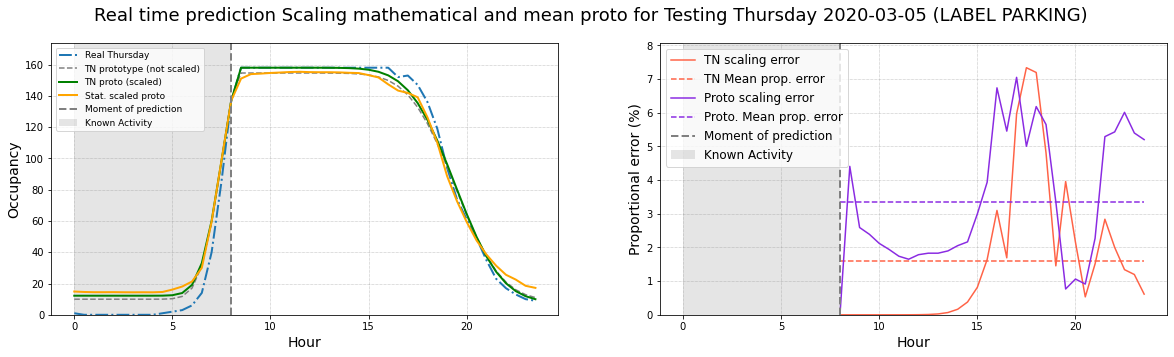

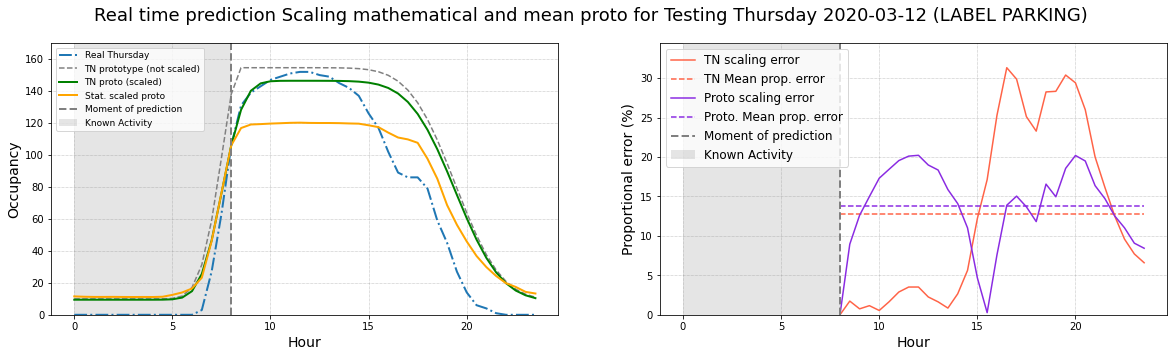

In [52]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 8
day = 'Thursday'

tn_arr_proto = tn_arr_weekday
tn_dep_proto = tn_dep_weekday
plot_prototype()

### FRIDAY

2020-02-28
51 cars could not park
Real Friday scaled prtotype error:  7.12 %
Real Friday scaled prtotype STDV:  6.689128174735353
Real Friday scaled TN error:  2.32 %
Real Friday scaled TN STDV:  2.548578297486739
_____________________________________________________________
2020-03-06
43 cars could not park
Real Friday scaled prtotype error:  9.06 %
Real Friday scaled prtotype STDV:  6.972271177614588
Real Friday scaled TN error:  5.09 %
Real Friday scaled TN STDV:  4.075641219076208
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  9.68 %
Real Friday scaled prtotype STDV:  4.5856279512161455
Real Friday scaled TN error:  7.54 %
Real Friday scaled TN STDV:  5.655462132248567
_____________________________________________________________


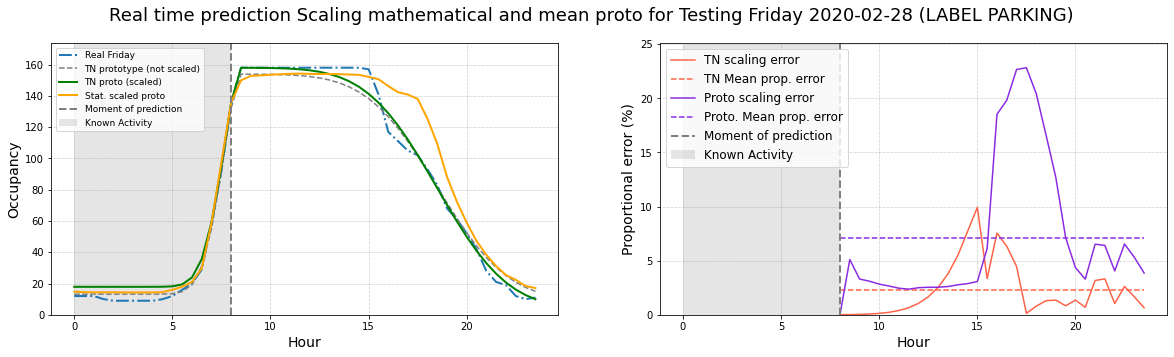

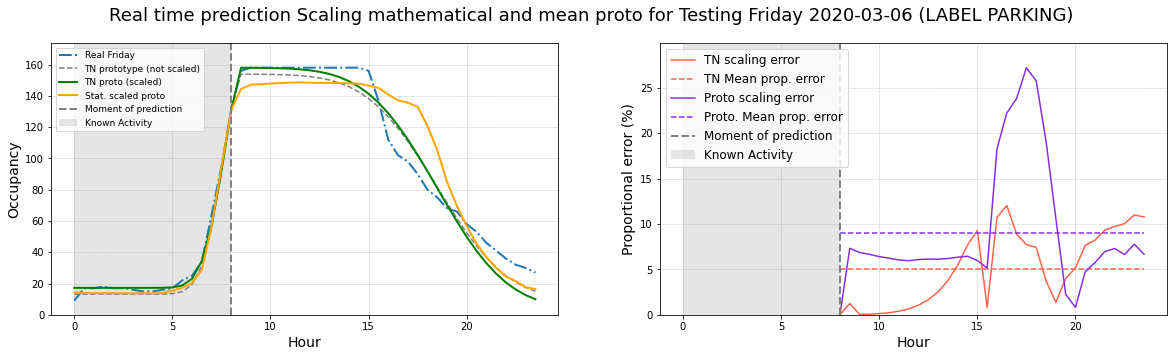

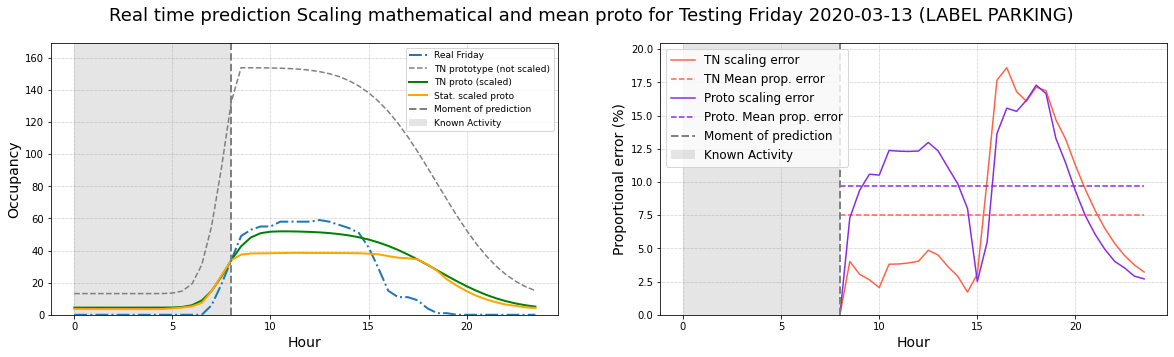

In [53]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 8
day = 'Friday'

tn_arr_proto = tn_arr_friday
tn_dep_proto = tn_dep_friday
plot_prototype() 

### WEEKEND

### SATURDAY

2020-02-22
Real Saturday scaled prtotype error:  2.99 %
Real Saturday scaled prtotype STDV:  2.403517530446649
Real Saturday scaled TN error:  2.85 %
Real Saturday scaled TN STDV:  1.724109526483923
_____________________________________________________________
2020-02-29
Real Saturday scaled prtotype error:  2.1 %
Real Saturday scaled prtotype STDV:  2.1865202491097264
Real Saturday scaled TN error:  2.04 %
Real Saturday scaled TN STDV:  1.763387857140034
_____________________________________________________________


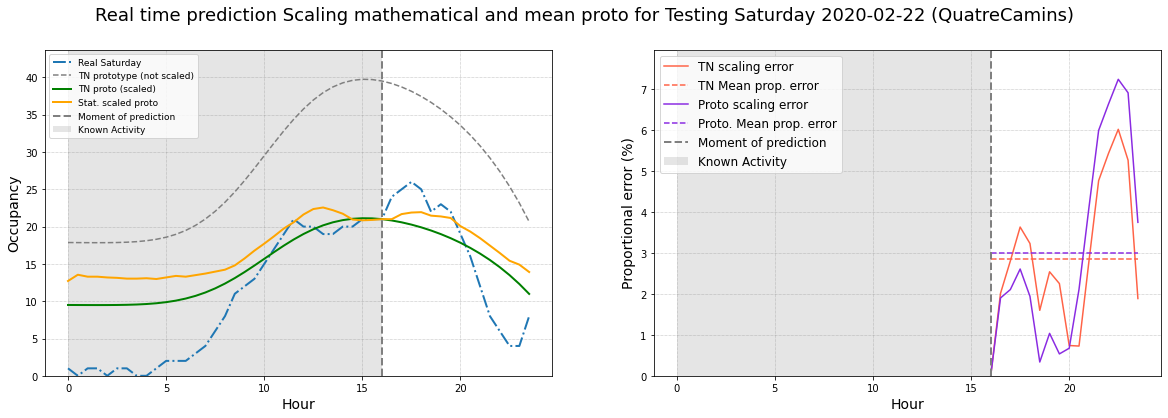

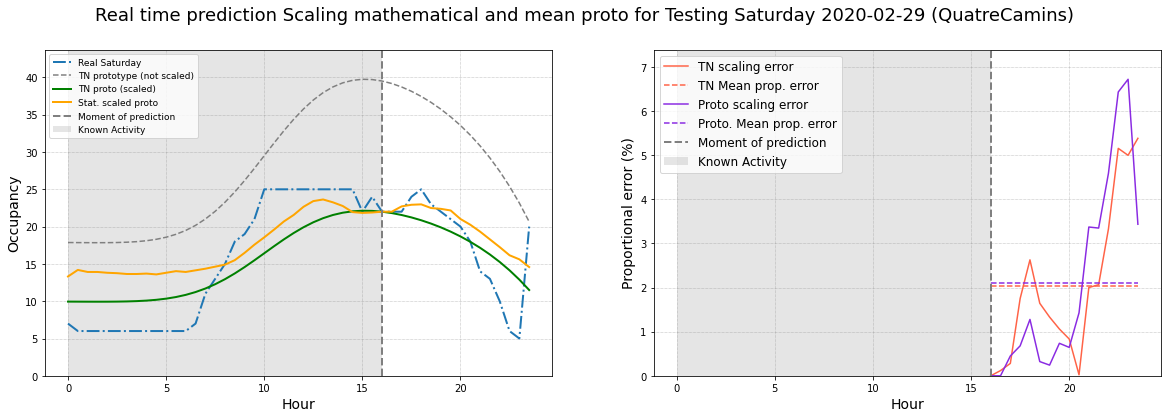

In [54]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

2020-02-23
Real Sunday scaled prtotype error:  3.97 %
Real Sunday scaled prtotype STDV:  2.2198140752279336
Real Sunday scaled TN error:  4.21 %
Real Sunday scaled TN STDV:  1.9508622516963088
_____________________________________________________________
2020-03-01
Real Sunday scaled prtotype error:  3.63 %
Real Sunday scaled prtotype STDV:  2.686988051060659
Real Sunday scaled TN error:  3.31 %
Real Sunday scaled TN STDV:  2.7297754783622574
_____________________________________________________________
2020-03-08
Real Sunday scaled prtotype error:  2.81 %
Real Sunday scaled prtotype STDV:  2.256061162461584
Real Sunday scaled TN error:  2.33 %
Real Sunday scaled TN STDV:  1.9179839708289363
_____________________________________________________________


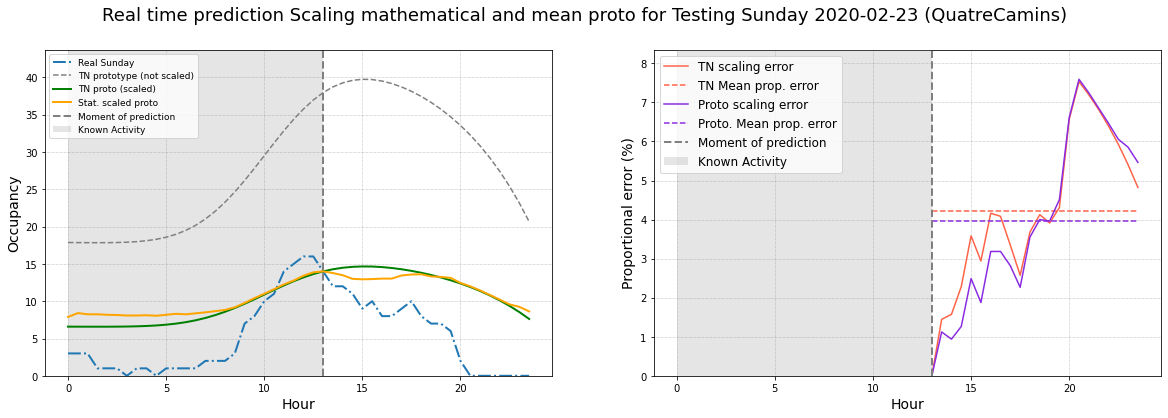

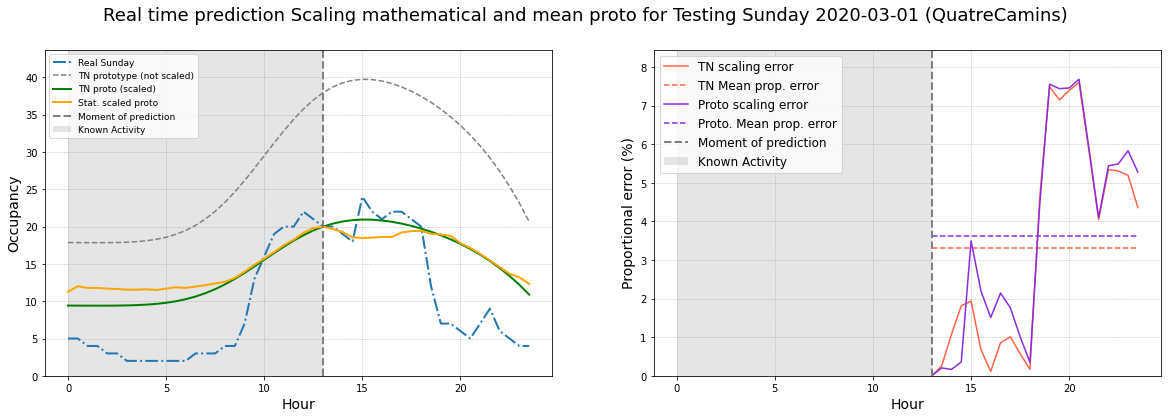

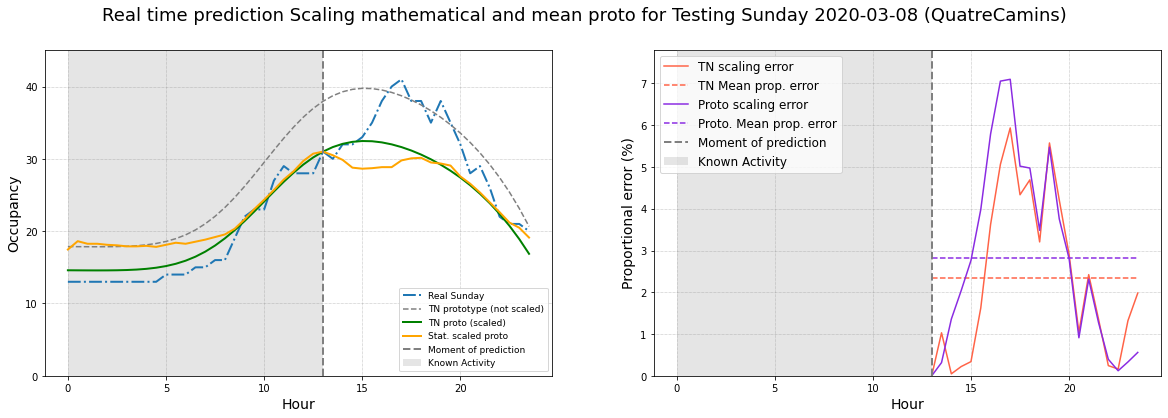

In [55]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1